In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Mitsubishi.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop(df2[(df2["Fiyat"] > 1000000)].index, axis=0, inplace=True)

In [4]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [5]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Attrage,Seri_Carisma,Seri_Colt,...,Model_1.8 GDI LX,Model_1.8 GLS,Model_2.0 GLS,Model_X,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,319500,0.090909,-0.194444,-1.096154,-0.089888,NaN,NaN,0,0,1,...,0,0,0,0,0,0,1,0,0,1
1,195000,-1.090909,-0.027778,0.197115,0.711610,NaN,NaN,0,1,0,...,1,0,0,0,1,0,0,0,1,0
2,158000,-1.000000,-0.333333,0.177885,0.471910,NaN,NaN,0,1,0,...,0,0,0,0,0,0,1,1,0,0
3,175000,-1.090909,-0.333333,0.177885,1.258427,NaN,NaN,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,335000,-0.454545,-0.111111,0.115385,0.197004,1.0,0.0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [6]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [8]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [9]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [10]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_5588\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,47039.950028,1.118617e+09,33445.731401,27531.052136


In [11]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [12]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-05-23 21:15:22,828] A new study created in memory with name: no-name-9331e3dc-7a82-483e-8dbf-d45adf5a1770
[I 2023-05-23 21:15:22,932] Trial 0 finished with value: 313463.83915761905 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.00889164944072711, 'max_depth': 12, 'min_child_weight': 276}. Best is trial 0 with value: 313463.83915761905.
[I 2023-05-23 21:15:22,936] Trial 1 finished with value: 313463.83915761905 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.001065969685062147, 'max_depth': 12, 'min_child_weight': 231}. Best is trial 0 with value: 313463.83915761905.
[I 2023-05-23 21:15:22,945] Trial 2 finished with value: 313463.83915761905 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.0032488172488348344, 'max_depth': 15, 'min_child_weight': 279}. Best is trial 0 with value: 313463.83915761905.
[I 2023-05-23 21:15:22,952] Trial 3 finished with value: 313463.83915761905 and paramete

[I 2023-05-23 21:15:23,799] Trial 28 finished with value: 56246.38824133943 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.40621735745790327, 'max_depth': 3, 'min_child_weight': 40}. Best is trial 28 with value: 56246.38824133943.
[I 2023-05-23 21:15:23,814] Trial 30 finished with value: 55816.03768843031 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4680917841236966, 'max_depth': 3, 'min_child_weight': 42}. Best is trial 30 with value: 55816.03768843031.
[I 2023-05-23 21:15:23,882] Trial 32 finished with value: 63919.05839995121 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.3969018160537232, 'max_depth': 3, 'min_child_weight': 49}. Best is trial 30 with value: 55816.03768843031.
[I 2023-05-23 21:15:23,939] Trial 33 finished with value: 59536.29472750192 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.41186813022362845, 'max_depth': 3, 'min_child_weight': 46}

[I 2023-05-23 21:15:25,058] Trial 59 finished with value: 313463.83915761905 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.30556146427576597, 'max_depth': 4, 'min_child_weight': 290}. Best is trial 49 with value: 50021.21778448578.
[I 2023-05-23 21:15:25,119] Trial 63 finished with value: 212891.18885881535 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.04303886741678466, 'max_depth': 3, 'min_child_weight': 22}. Best is trial 49 with value: 50021.21778448578.
[I 2023-05-23 21:15:25,126] Trial 62 finished with value: 313463.83915761905 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.2535471478356235, 'max_depth': 3, 'min_child_weight': 119}. Best is trial 49 with value: 50021.21778448578.
[I 2023-05-23 21:15:25,133] Trial 61 finished with value: 313463.83915761905 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.30774411867448537, 'max_depth': 3, 'min_child_weigh

[I 2023-05-23 21:15:26,786] Trial 90 finished with value: 32579.711617144676 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.39560121357825223, 'max_depth': 7, 'min_child_weight': 2}. Best is trial 85 with value: 31084.696691869274.
[I 2023-05-23 21:15:26,828] Trial 91 finished with value: 33450.37045954625 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.4141527298249754, 'max_depth': 7, 'min_child_weight': 4}. Best is trial 85 with value: 31084.696691869274.
[I 2023-05-23 21:15:26,829] Trial 93 finished with value: 34868.07655810796 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.4717078587599159, 'max_depth': 7, 'min_child_weight': 3}. Best is trial 85 with value: 31084.696691869274.
[I 2023-05-23 21:15:26,838] Trial 94 finished with value: 31492.294783789624 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.47798789454435453, 'max_depth': 7, 'min_child_weight': 1

[I 2023-05-23 21:15:28,228] Trial 120 finished with value: 313463.83915761905 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.32484139194925943, 'max_depth': 7, 'min_child_weight': 210}. Best is trial 92 with value: 30624.909223628776.
[I 2023-05-23 21:15:28,286] Trial 121 finished with value: 313463.83915761905 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.1671187629587328, 'max_depth': 7, 'min_child_weight': 184}. Best is trial 92 with value: 30624.909223628776.
[I 2023-05-23 21:15:28,347] Trial 122 finished with value: 313463.83915761905 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.3344923494667613, 'max_depth': 7, 'min_child_weight': 177}. Best is trial 92 with value: 30624.909223628776.
[I 2023-05-23 21:15:28,417] Trial 123 finished with value: 57936.52944099935 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.28427366395387094, 'max_depth': 7, 'min_child

[I 2023-05-23 21:15:29,815] Trial 150 finished with value: 39190.04521055297 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.27914286449621306, 'max_depth': 9, 'min_child_weight': 11}. Best is trial 92 with value: 30624.909223628776.
[I 2023-05-23 21:15:29,856] Trial 152 finished with value: 40798.160315567424 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.26491332796982864, 'max_depth': 9, 'min_child_weight': 11}. Best is trial 92 with value: 30624.909223628776.
[I 2023-05-23 21:15:29,903] Trial 153 finished with value: 40411.33206353462 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.2724065620939338, 'max_depth': 9, 'min_child_weight': 1}. Best is trial 92 with value: 30624.909223628776.
[I 2023-05-23 21:15:29,911] Trial 151 finished with value: 313463.83915761905 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.2809114977455444, 'max_depth': 9, 'min_child_weig

[I 2023-05-23 21:15:31,382] Trial 180 finished with value: 246105.33957090208 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.025029644203153244, 'max_depth': 6, 'min_child_weight': 13}. Best is trial 177 with value: 29280.435380574134.
[I 2023-05-23 21:15:31,399] Trial 181 finished with value: 250740.51931403542 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.023093158039321528, 'max_depth': 6, 'min_child_weight': 13}. Best is trial 177 with value: 29280.435380574134.
[I 2023-05-23 21:15:31,546] Trial 183 finished with value: 119271.69248672664 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.20072733736723133, 'max_depth': 7, 'min_child_weight': 85}. Best is trial 177 with value: 29280.435380574134.
[I 2023-05-23 21:15:31,580] Trial 184 finished with value: 119518.01838335609 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.1982912036275587, 'max_depth': 7, 'min_c

[I 2023-05-23 21:15:33,129] Trial 211 finished with value: 43240.65801976449 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.24211360321680916, 'max_depth': 7, 'min_child_weight': 5}. Best is trial 177 with value: 29280.435380574134.
[I 2023-05-23 21:15:33,155] Trial 210 finished with value: 37953.58249912189 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.3033098291778223, 'max_depth': 7, 'min_child_weight': 6}. Best is trial 177 with value: 29280.435380574134.
[I 2023-05-23 21:15:33,172] Trial 212 finished with value: 36503.1118517905 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.3110901792965422, 'max_depth': 7, 'min_child_weight': 6}. Best is trial 177 with value: 29280.435380574134.
[I 2023-05-23 21:15:33,237] Trial 213 finished with value: 41615.164296167415 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.3013482754527401, 'max_depth': 7, 'min_child_weight

[I 2023-05-23 21:15:34,916] Trial 240 finished with value: 306321.99982321355 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.0024163426967290093, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 177 with value: 29280.435380574134.
[I 2023-05-23 21:15:34,974] Trial 241 finished with value: 167838.66455139284 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.06511905922841817, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 177 with value: 29280.435380574134.
[I 2023-05-23 21:15:35,142] Trial 242 finished with value: 39706.45341130539 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.3560064220551291, 'max_depth': 4, 'min_child_weight': 15}. Best is trial 177 with value: 29280.435380574134.
[I 2023-05-23 21:15:35,143] Trial 244 finished with value: 42914.800488246015 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.36346604311849906, 'max_depth': 4, 'min_chil

In [13]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 29280.4354
Best params:
	colsample_bytree: 0.9
	subsample: 0.8
	learning_rate: 0.34024075756124317
	max_depth: 7
	min_child_weight: 2


In [14]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.1, 0.3],
                  "max_depth": [7,10],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [0.9],
               'subsample': [0.8],
               'min_child_weight': [2]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST PARAMS:  {'colsample_bytree': 0.9, 'learning_rate': 0.3, 'max_depth': 10, 'min_child_weight': 2, 'n_estimators': 500, 'subsample': 0.8}
{'TestDeger': 45182.12452493255, 'MSE': 906731258.6813853, 'RMSE': 30111.978657693442, 'MAE': 24232.842633928572}


In [15]:
r2 = r2_score(y_test, y_pred)
r2

0.9319439946350442

In [16]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.8852189760262685

In [18]:
marka_model = joblib.dump(grid_final_model, "Mitsubishi.pkl")

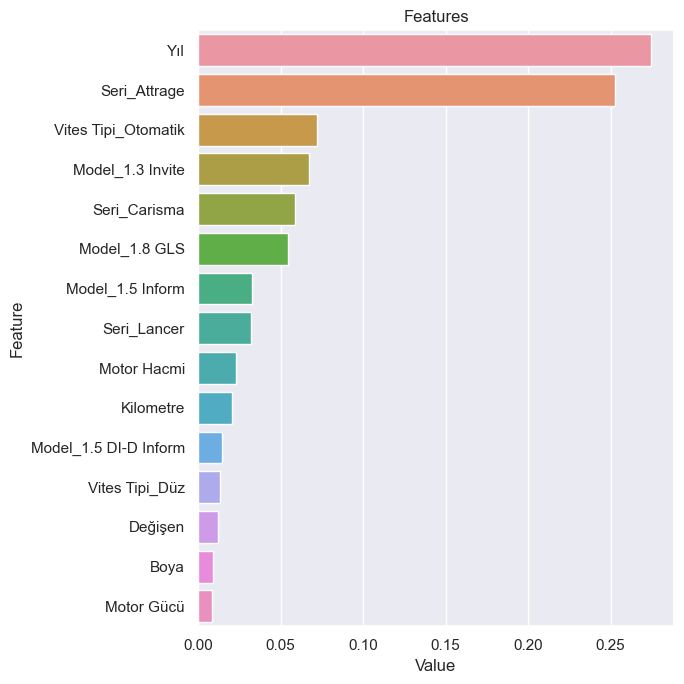

In [17]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(grid_final_model,X)

In [16]:
y_test2 = list(y_test)

In [17]:
df3 = pd.DataFrame(list(zip(y_test, y_pred,(y_pred-y_test))),
               columns =['test', 'pred',"fark"])

In [18]:
df3

,test,pred,fark
0,355000,322154.593750,-3.284541e+04
1,255000,291012.625000,3.601262e+04
2,170000,183332.703125,1.333270e+04
3,100000,121273.281250,2.127328e+04
4,230000,200349.781250,-2.965022e+04
5,245000,265271.218750,2.027122e+04
6,158000,160043.875000,2.043875e+03
7,215500,229758.343750,1.425834e+04
8,242000,245333.687500,3.333688e+03
9,175000,256523.593750,8.152359e+04


In [19]:
df3.describe([0.05,0.25, 0.75,0.90,0.99]).T

,count,mean,std,min,5%,25%,50%,75%,90%,99%,max
test,50.0,309160.020000,261548.860370,1.000000e+05,156350.000000,211250.000000,259500.000000,323750.000000,437000.000000,1.269900e+06,2.000000e+06
pred,50.0,295510.531250,114410.335938,6.720360e+04,149003.604687,219559.195312,268794.515625,337968.093750,501612.421875,5.336527e+05,5.442222e+05
fark,50.0,-13649.481719,215326.260091,-1.482542e+06,-43304.350000,-9219.273438,19976.234375,44778.398438,56752.362500,9.199224e+04,9.927894e+04


In [20]:
df3["test"].max()

2000000

In [21]:
df3[df3["test"]==2000000]

,test,pred,fark
36,2000000,517458.375,-1482541.625


In [29]:
df3[df3["test"] > 500000]

,test,pred,fark
36,2000000,517458.375,-1482541.625
49,510000,544222.250,34222.250


In [23]:
y_train2 = list(y_train)

In [28]:
for i in y_train2:
    if i > 500000:
        print(i)

635000
601000
505000
565000
612000
657500
608000
570000
